In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0704 22:49:58.390467 4642125248 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Fashion MNIST Data

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

In [4]:
y_train.shape

(60000,)

In [5]:
#One hot the labels
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
x_train_master, y_train_master = x_train[:30000], y_train[:30000]
x_train_slave, y_train_slave = x_train[30000:], y_train[30000:]

In [7]:
#Flatten everything
x_train_master_flat, input_shape = flatten_mnist(x_train_master) 
x_train_slave_flat, _ = flatten_mnist(x_train_slave)
x_test_flat, _  = flatten_mnist(x_test)

In [8]:
test_shape = x_test_flat.shape

In [9]:
x_test_random_flat = np.random.uniform(0, 1, test_shape)

# Train Master

In [10]:
#Configurations
eps_train = 0.1                                                                                                                            
eps_test = 0.1                                                                                                                             
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"                                                                                                               
load_weights = False                                                                                                              
load_counter = 234                                                                                                            
sigma = tf.nn.relu                                                                                                                         
epochs, reg, lr = 3, 0.00, 1e-3    
#epochs, reg, lr = 30, 0.00, 15e-4                                                                                                          
pgd_eta, pgd_num_iter = 1e-2, 50

In [11]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 32]
dataset = ((x_train_master_flat, y_train_master), (x_test_flat, y_test))

scope_name = "teacher_student_fashion"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        model.fit(sess, x_train_master_flat, y_train_master, training_epochs = epochs, reg_op = reg , lr = lr)
        
        margins_master = model.get_pointwise_margin(sess, x_train_master_flat, y_train)
        
        weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(weight_norms)
        
        """
        #Save weights
        weights = tf.trainable_variables()
        #weights = model.get_weights()[0] + model.get_weights()[1]
        saver = tf.train.Saver(weights)
        weights_path = saver.save(sess, weights_dir + "model_" + str(counter) + ".ckpt")
        print("Saved model at %s"%weights_path)
        """
        
        #Test model - regular, fgsm adv, pgd adv
        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        print("----Regular test accuracy and loss ----")
        print((loss_reg, acc_reg))
        
        loss_fgsm, acc_fgsm, deltas_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
        print("----FGSM test accuracy and loss ----")
        print((loss_fgsm, acc_fgsm))
        
        loss_pgd, acc_pgd, deltas_pgd = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=pgd_eta, num_iter = pgd_num_iter)
        print("----PGD test accuracy and loss ----")
        print((loss_pgd , acc_pgd))

Initialized instance variables of the robust model class
I0704 22:50:00.343858 4642125248 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0704 22:50:00.345285 4642125248 deprecation_wrapper.py:119] From ../../../feedforward_robust.py:36: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0704 22:50:00.367156 4642125248 feedforward_robust.py:40] Created placeholders for x and y
W0704 22:50:00.368518 4642125248 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0704 22:50:00.387407 4642125248 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0704 22:50:00.400591 4642125248 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:36: The name tf.get_variable

Created model successfully. Now going to train


W0704 22:50:01.329941 4642125248 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
Epoch: 0001    cost: 0.602290839 
I0704 22:50:02.773890 4642125248 feedforward_robust.py:751] Epoch: 0001    cost: 0.602290839 
Accuracy on batch: 0.812500
I0704 22:50:02.775295 4642125248 feedforward_robust.py:752] Accuracy on batch: 0.812500
Epoch: 0002    cost: 0.423337503 
I0704 22:50:03.745182 4642125248 feedforward_robust.py:751] Epoch: 0002    cost: 0.423337503 
Accuracy on batch: 0.843750
I0704 22:50:03.746630 4642125248 feedforward_robust.py:752] Accuracy on batch: 0.843750
Epoch: 0003    cost: 0.379834467 
I0704 22:50:04.694087 4642125248 feedforward_robust.py:751] Epoch: 0003    cost: 0.379834467 
Accuracy on batch: 0.875000
I0704 22:50:04.695171 4642125248 fe

----- Weight norms ----
[17.560528, 9.236234, 7.4632244, 4.8046856]
----Regular test accuracy and loss ----
(0.4298507, 0.8453)


Model is being evaluated on FGSM data
I0704 22:50:05.205718 4642125248 feedforward_robust.py:670] Model is being evaluated on FGSM data
Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations
I0704 22:50:05.278076 4642125248 feedforward_robust.py:672] Model is being evaluated on PGD points generated using 0.010000 learning rate and 50 iterations


----FGSM test accuracy and loss ----
(7.5254445, 0.0365)
iteration: 0
loss 0.748103
iteration: 20
loss 11.352206
iteration: 40
loss 12.163715


This is to confirm that attack does not violate constraints
I0704 22:50:10.112802 4642125248 feedforward_robust.py:517] This is to confirm that attack does not violate constraints
Should be no more than eps
I0704 22:50:10.113985 4642125248 feedforward_robust.py:518] Should be no more than eps
0.10000005352730845
I0704 22:50:10.214136 4642125248 feedforward_robust.py:519] 0.10000005352730845


----PGD test accuracy and loss ----
(12.236209, 0.0109)


## Observe deltas pgd. Are they at boundary?

In [21]:
deltas_pgd.shape

(10000, 784)

(7840000,)


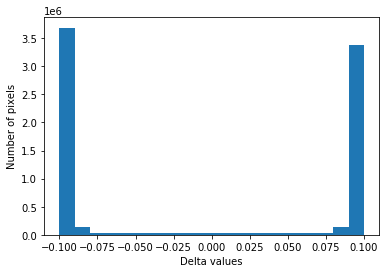

In [24]:
deltas_flat = deltas_pgd.flatten()
print(deltas_flat.shape)
plt.hist(deltas_flat, 20)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel("Delta values")
plt.ylabel("Number of pixels")
plt.savefig("/Users/adhyyan/Desktop/delta_hist.pdf")

## Inspect margins

In [ ]:
margins_master

In [ ]:
plt.hist(margins_master, 5)

## Generate data for slave

In [ ]:
with tf.variable_scope(scope_name, reuse = False) as scope:
        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        print("----Regular test accuracy and loss ----")
        print((loss_reg, acc_reg))
        
        z_train_slave = model.get_prediction(sess, x_train_slave_flat)
        z_test_slave = model.get_prediction(sess, x_test_flat)
        z_test_random_master = model.get_prediction(sess, x_test_random_flat)

In [ ]:
z_train_slave[0]

# Train slave

In [ ]:
#Setup - Dataset stuff
def slave_training():
    epochs = 30
    lr = 15e-4
    tf.reset_default_graph()
    sess = tf.Session()
    hidden_sizes = [64, 64, 32]
    dataset = ((x_train_slave_flat, z_train_slave), (x_test_flat, y_test))

    scope_name = "teacher_student_fashion"
    if not load_weights:
        with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:

            logdir = tensorboard_dir + str(counter)

            #Create model
            writer = tf.summary.FileWriter(logdir)
            model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma, classification = False)
            sess.run(tf.global_variables_initializer())
            print("Created model successfully. Now going to train")

            #Train model
            model.fit(sess, x_train_slave_flat, z_train_slave, training_epochs = epochs, reg_op = reg , lr = lr)

            """
            #Save weights
            weights = tf.trainable_variables()
            #weights = model.get_weights()[0] + model.get_weights()[1]
            saver = tf.train.Saver(weights)
            weights_path = saver.save(sess, weights_dir + "model_" + str(counter) + ".ckpt")
            print("Saved model at %s"%weights_path)
            """
            loss_real_train, acc_train = model.evaluate(sess, x_train_slave_flat, z_train_slave)

            #Test model - regular, fgsm adv, pgd adv
            loss_real_reg, acc_real_reg = model.evaluate(sess, x_test_flat, z_test_slave)
            print("----Real test loss and accuracy comparing to teacher ----")
            print((loss_real_reg, acc_real_reg))
            
            loss_class_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
            print("----Regular test loss and accuracy ----")
            print((loss_class_reg, acc_reg))

            loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
            print("----FGSM test loss and accuracy ----")
            print((loss_fgsm, acc_fgsm))

            loss_pgd, acc_pgd = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=pgd_eta, num_iter = pgd_num_iter)
            print("----PGD test loss and accuracy ----")
            print((loss_pgd , acc_pgd))
            
            slave_train_confidences = model.get_prediction(sess, x_train_slave_flat)
            slave_test_confidences = model.get_prediction(sess, x_test_flat)
            slave_random_confidences = model.get_prediction(sess, x_test_random_flat)
            
            return loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg, slave_train_confidences, slave_test_confidences, slave_random_confidences
        
        

In [ ]:
tup = slave_training()

In [ ]:
list(tup)

In [ ]:
df = pd.DataFrame()
df['mse on z_train'] = []
df['acc on z_train'] = []
df['mse on z_test'] = []
df['acc on z_test'] = []
df['acc on y_test'] = []

In [ ]:
train_confidences = []
test_confidences = []
random_confidences = []
for i in range(3):
    loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg, slave_train_confidences, slave_test_confidences, random_conf = slave_training()
    df.loc[i] = [loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg]
    train_confidences.append(slave_train_confidences)
    test_confidences.append(slave_test_confidences)
    random_confidences.append(random_conf)

In [ ]:
import scipy

In [ ]:
num_test = len(x_test)
idx_random = np.random.choice(num_test, 10)
for idx in idx_random:
    x = np.arange(10)
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x - width/2, scipy.special.softmax(random_confidences[0][idx]), width, label = 'slave 1')
    ax.bar(x - 3*width/2, scipy.special.softmax(random_confidences[1][idx]), width, label = 'slave 2')
    ax.bar(x + width/2, scipy.special.softmax(random_confidences[2][idx]), width, label = 'slave 3')
    ax.bar(x + 3*width/2, scipy.special.softmax(z_test_random_master[idx]), width, label = 'master')
    ax.set_ylabel('Confidences')
    ax.legend()

In [ ]:
df

In [ ]:
#df.to_excel("ts_fashion_results.xlsx")  